##### Estadisticas generales sobre el covid-19

In [1]:
import numpy as np

from utilidades import *

# data = load_data_jhu('peru')
data = load_data()
x = range(len(data[0]))

##### Casos

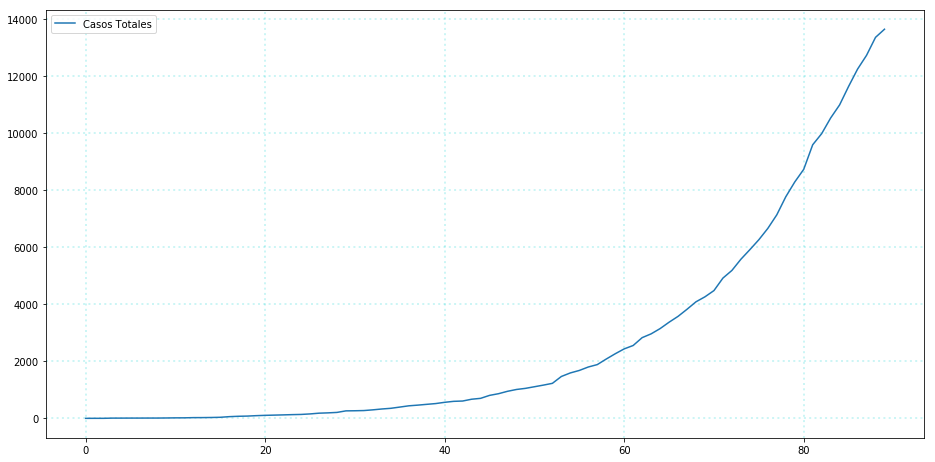

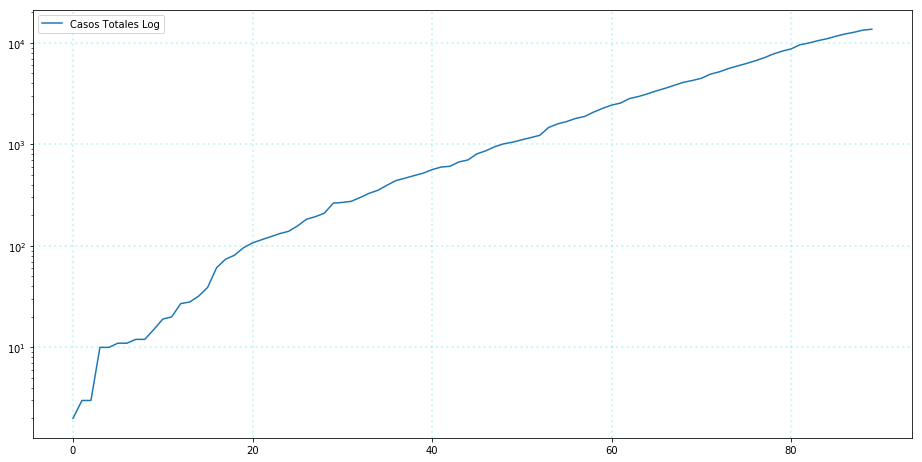

In [2]:
ax = plot(x, data[1], labels=['Casos Totales'])
ax = plot(x, data[1], labels=['Casos Totales Log'])
ax.set_yscale('log')

inc avg (15d/5d): 1.19


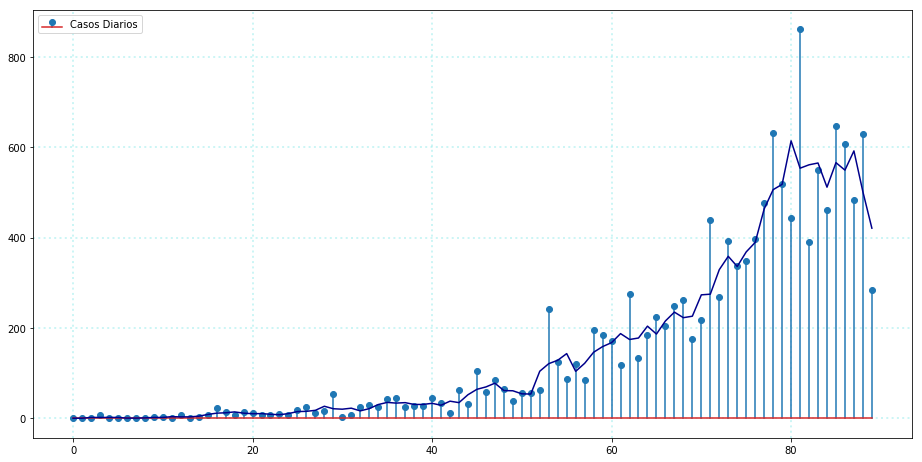

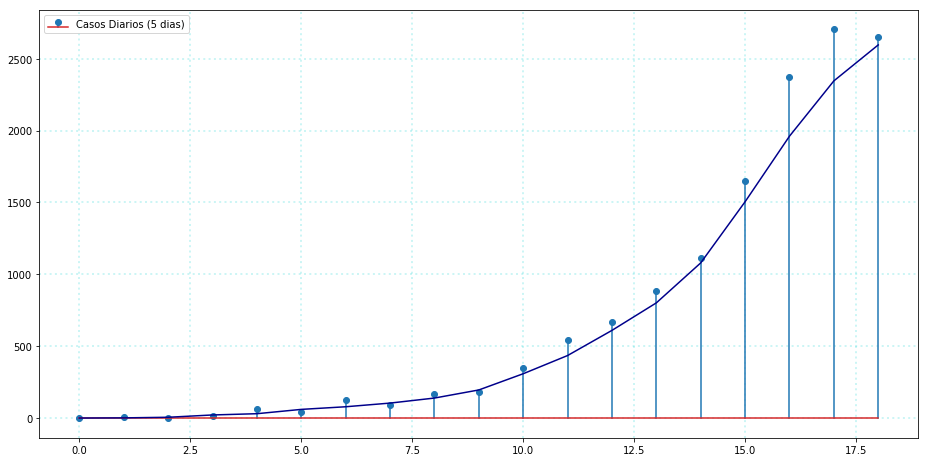

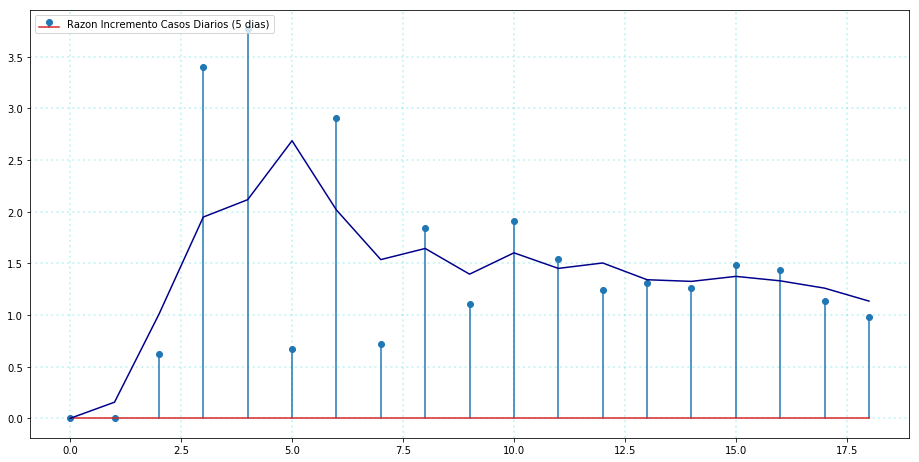

In [3]:
def accumulate(arr, nth = 5):
    pad_arr = np.pad(
        arr, 
        (nth - len(arr) % nth, 0), 
        'constant', 
        constant_values=(0,)
    )
    return np.reshape(pad_arr, (-1, nth)).sum(axis=-1)

new_cases = np.diff(data[1], prepend=[data[1][0]])
plot_moving_averaged(new_cases, label='Casos Diarios')

cum_cases = accumulate(new_cases)
plot_moving_averaged(cum_cases, label='Casos Diarios (5 dias)')

# Si menor a 1, los casos se estan reduciendo (perfecto)
# Si entre 1 y 2, los casos se estan duplicado en mas de 5 dias (mas o menos, depende cuan cerca este al 1)
# Si igual a 2, los casos se estan duplicando cada 5 dias (preocupante)
# Si mayor a 2, los casos se estan duplicando en menos de 5 dias (muy preocupante)
cum_cases[cum_cases < 1.] = 1.
inc_cases = [0] * 2 + [cum_cases[_ + 1] / cum_cases[_] for _ in range(1, len(cum_cases) - 1)]
inc_cases = np.array(inc_cases)
inc_cases[inc_cases > 10.] = 10.
plot_moving_averaged(inc_cases, label='Razon Incremento Casos Diarios (5 dias)')

print('inc avg (15d/5d): {:.2f}'.format(np.mean(inc_cases[-3:])))

###### R_t 

avg Rt m1 (30d): 1.3377154450408675
r_ts[-1]: 0.8332869733840909 +- 0.07565710608098652

avg Rt m2 (30d): 1.232424650121494
r_ts[-1]: 1.0 +- 0.18080201015885963


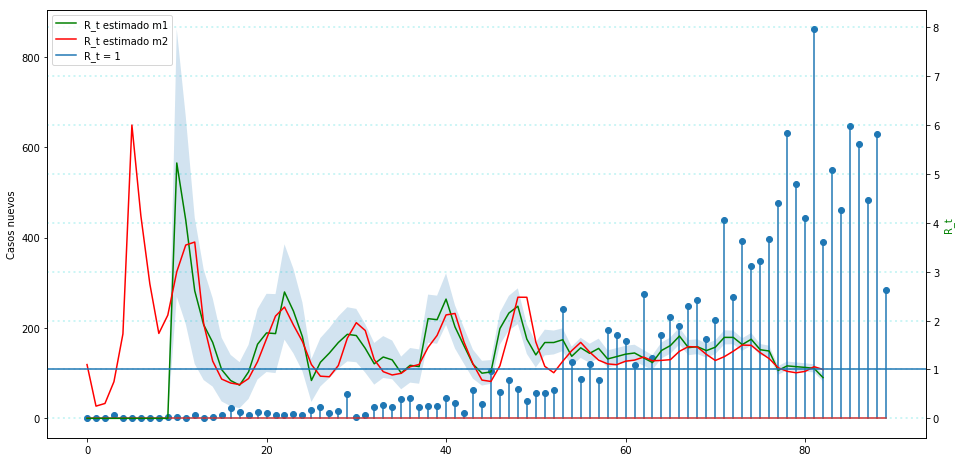

In [4]:
r_ts, r_ts_min, r_ts_max = estimate_rt(new_cases, window_size=3)

fig, ax = pyplot.subplots()
ax.stem(new_cases)
ax.set_ylabel('Casos nuevos')

ax2 = ax.twinx()
ax2.set_ylabel('R_t', color='green')
ax2.plot(r_ts, color='green', label='R_t estimado m1')
ax2.fill_between(
    range(len(r_ts)),
    r_ts_min,
    r_ts_max,
    alpha=0.2
)

print('avg Rt m1 (30d): {}\nr_ts[-1]: {} +- {}'.format(
    np.mean(r_ts[r_ts > 0][-30:]),
    r_ts[-1], r_ts_max[-1] - r_ts[-1]
))


def estimate_rt_2(new_cases, window_size=0):
    rts = []
    if window_size > 0:
        new_cases = moving_average(new_cases, window_size)
                
    for idx in range(7, len(new_cases) + 1):
        rt = sum(new_cases[idx - 3: idx]) / max(1., sum(new_cases[idx - 7:idx - 4]))
        rts.append(rt)
        
    rts = np.array(rts)
    rts[rts > 6.] = 6.
    
    return rts[:-1]

r_ts_2 = estimate_rt_2(new_cases, window_size=3)
ax2.plot(r_ts_2, color='red', label='R_t estimado m2')
print('\navg Rt m2 (30d): {}\nr_ts[-1]: {} +- {}'.format(
    np.mean(r_ts_2[r_ts_2 > 0][-30:]), 
    r_ts_2[-1], np.std(r_ts_2[-7:]) * 2.
))

ax2.axhline(1., label='R_t = 1')

pyplot.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
_ = ax2.legend(loc='upper left')

Refs   
[1]: https://stochastik-tu-ilmenau.github.io/COVID-19/reports/repronum/repronum.pdf   
[2]: https://biocomsc.upc.edu/en/covid-19/Methods.pdf/view

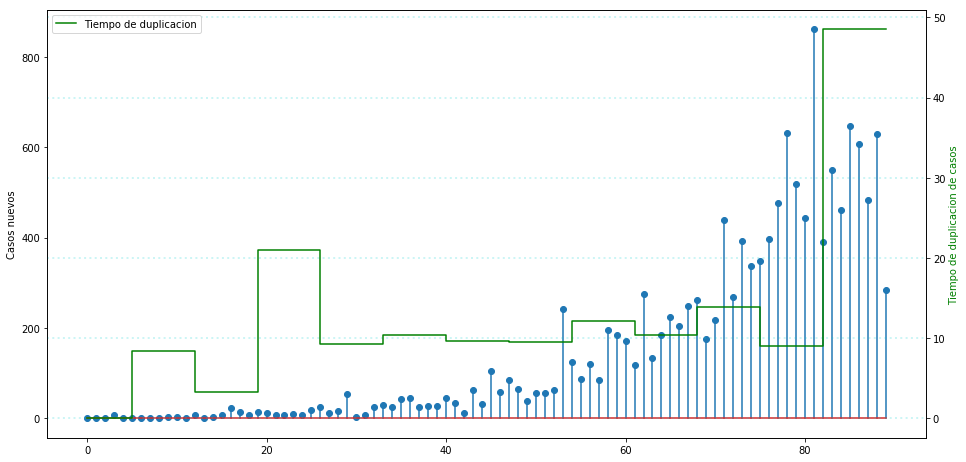

In [5]:
# razon_incremento^x = 2
def doubling_times(new_cases):
    dts = [0]

    for idx in range(1, len(new_cases)):
        diff = max(
            1, new_cases[idx] / max(1., new_cases[idx - 1])
        )
        dts.append(7 * np.log(2) / max(.1, np.log(diff)))
    
    return dts

cum_cases_week = accumulate(new_cases, nth=7)
dts = doubling_times(cum_cases_week)

fig, ax = pyplot.subplots()
ax.stem(new_cases)
ax.set_ylabel('Casos nuevos')

dts = np.repeat(dts, 7)[-1 * len(new_cases):]
ax2 = ax.twinx()
ax2.set_ylabel('Tiempo de duplicacion de casos', color='green')
ax2.step(range(len(dts)), dts, color='green', label='Tiempo de duplicacion')

pyplot.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
_ = ax2.legend(loc='upper left')


##### Fallecidos

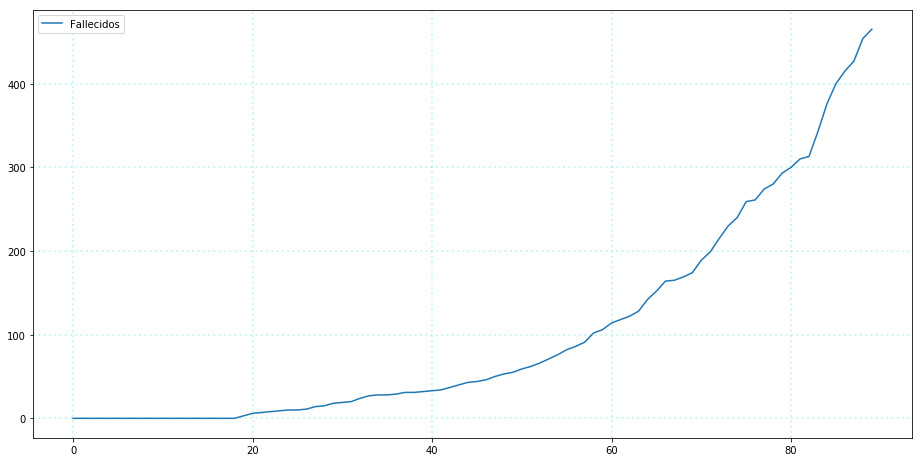

In [6]:
_ = plot(x, data[2], labels=['Fallecidos'])

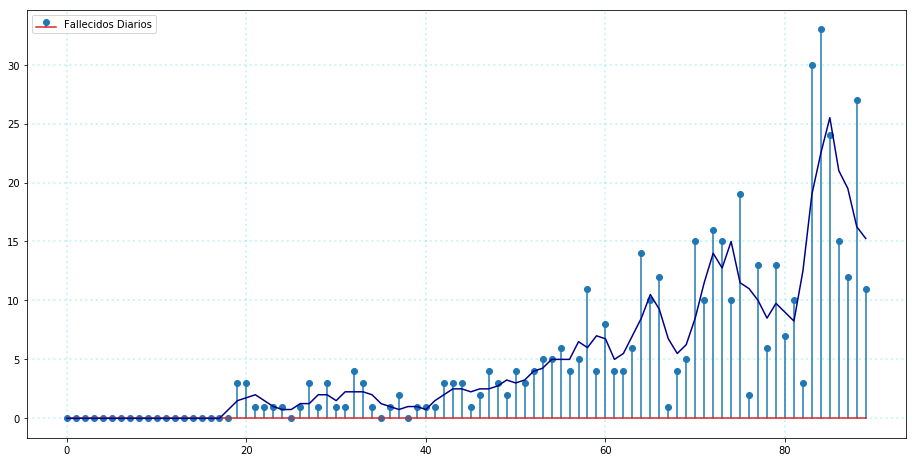

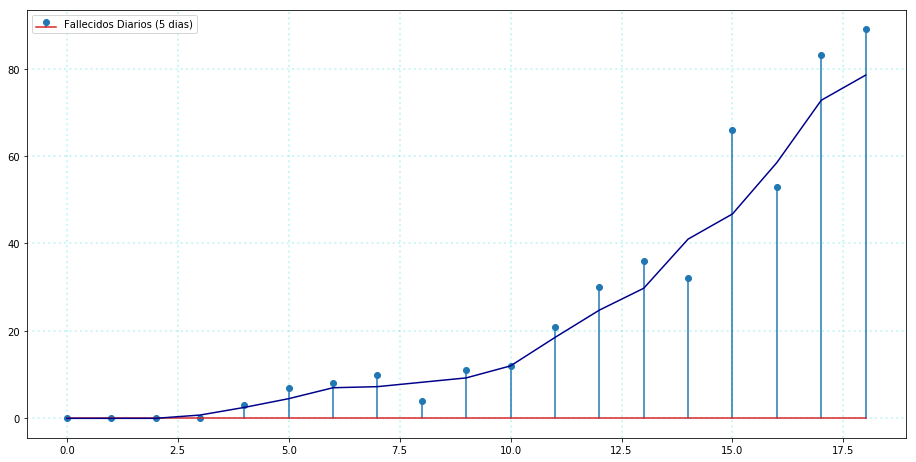

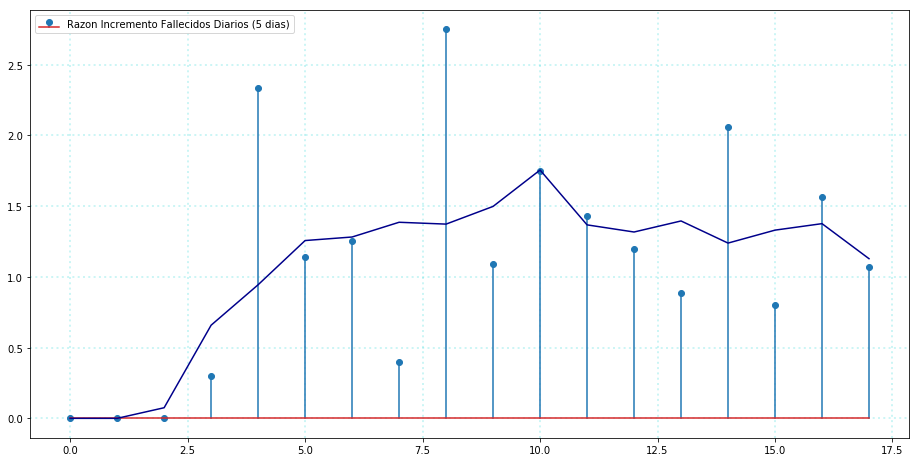

In [7]:
new_deaths = np.diff(data[2], prepend=[data[2][0]])
plot_moving_averaged(new_deaths, label='Fallecidos Diarios')

cum_deaths = accumulate(new_deaths)
plot_moving_averaged(cum_deaths, label='Fallecidos Diarios (5 dias)')

# Si menor a 1, los casos se estan reduciendo (perfecto)
# Si entre 1 y 2, los casos se estan duplicado en mas de 5 dias (mas o menos, depende cuan cerca este al 1)
# Si igual a 2, los casos se estan duplicando cada 5 dias (preocupante)
# Si mayor a 2, los casos se estan duplicando en menos de 5 dias (muy preocupante)
inc_deaths = [cum_deaths[_ + 1] / (cum_deaths[_] or 10.) for _ in range(len(cum_deaths) - 1)]
_ = plot_moving_averaged(inc_deaths, label='Razon Incremento Fallecidos Diarios (5 dias)')

###### Recuperados 

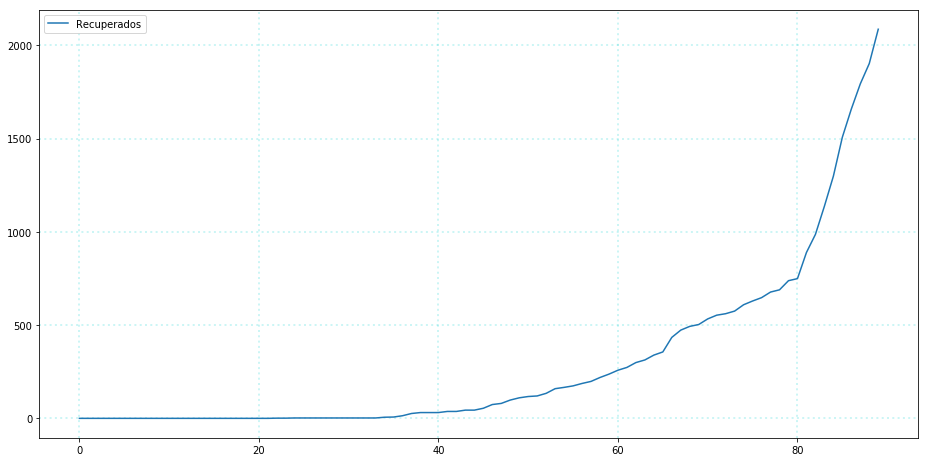

In [8]:
_ = plot(x, data[3], labels=['Recuperados'])

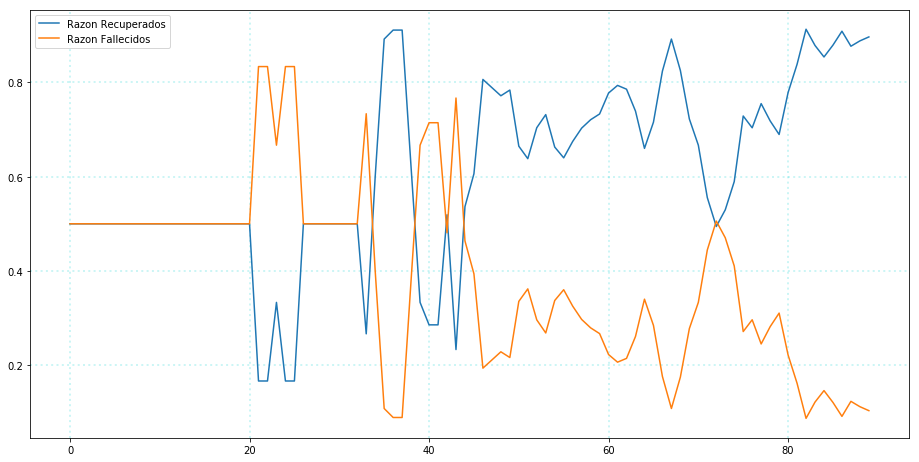

In [9]:
new_recovered = np.diff(data[3], prepend=[data[3][0]])

closed_cases = new_recovered + new_deaths
closed_cases[closed_cases < 1] = 1

recovered_rate = new_recovered / closed_cases
recovered_rate = moving_average(recovered_rate, 3)
recovered_rate[recovered_rate < .001] = .5

_ = plot(
    x, recovered_rate, 1 - recovered_rate,
    labels=['Razon Recuperados', 'Razon Fallecidos']
)

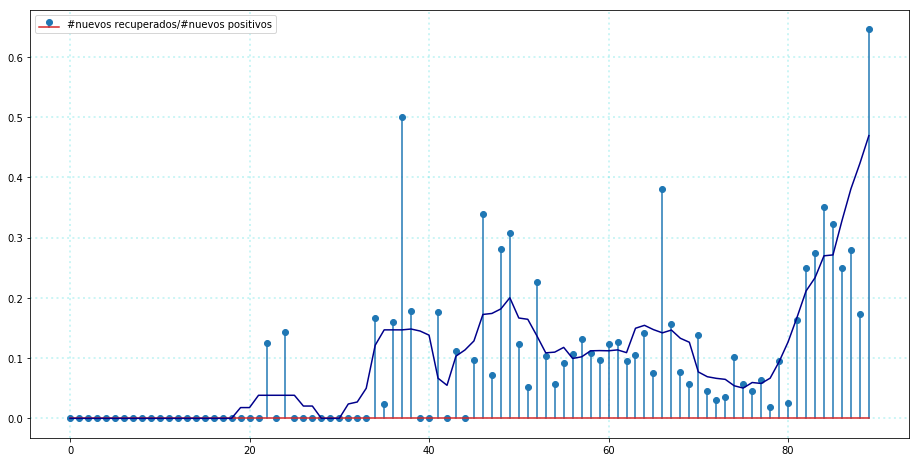

In [10]:
new_cases[new_cases < 1] = 1

ax = plot_moving_averaged(
    new_recovered / new_cases, 
    label='#nuevos recuperados/#nuevos positivos',
    window_size = 7
)

##### Tests

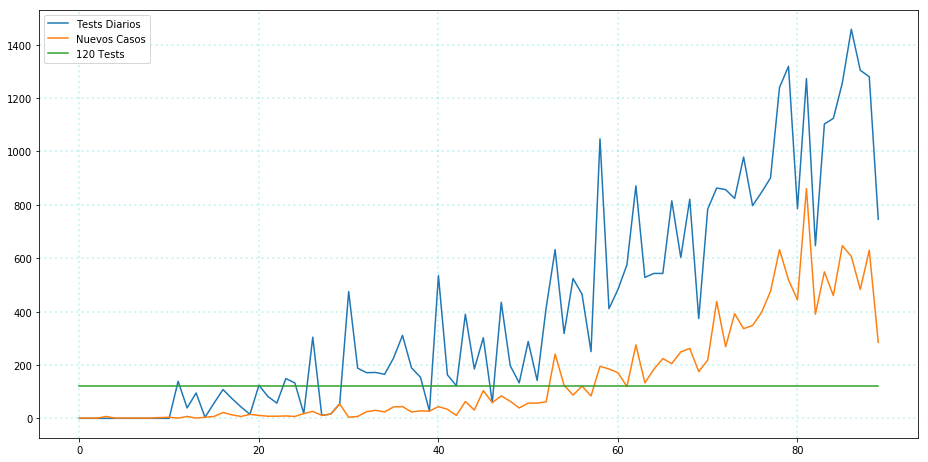

In [11]:
_ = plot(x, data[-1], new_cases, [120] * len(x), labels=['Tests Diarios', 'Nuevos Casos', '120 Tests'])

Tests Diarios = <a href='https://github.com/mauforonda/covid19-bolivia/blob/master/descartados.csv'>Descartados</a> + <a href='https://github.com/mauforonda/covid19-bolivia2/blob/master/nacional.csv'>Nuevos Casos</a>
Como referencia el 04/24, en el <a href='https://www.boliviasegura.gob.bo/comunicados_proc.php?Seleccion=23'>reporte del ministerio</a> indica que '4.490 casos fueron descartados mediante pruebas de laboratorio', misma cantidad que esta en los datos compilados por <a href='https://github.com/mauforonda'>@mauforonda</a>.  
Los datos a partir del 2020-05-02 fueron recogidos y procesados por la revista <a href='https://muywaso.com/especial-de-datos-muy-waso-sobre-el-coronavirus-en-bolivia/'>muywaso.com</a>.

Cuantos tests se necesitan para encontar un caso positivo?

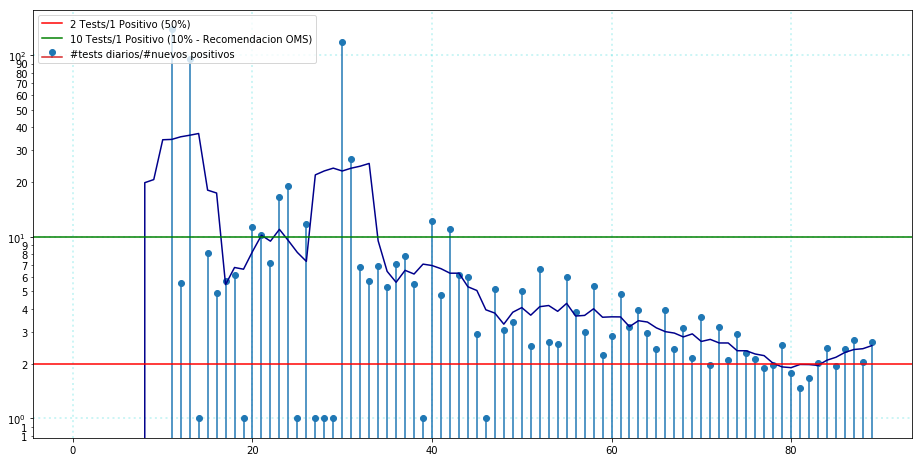

In [12]:
ax = plot_moving_averaged(
    data[-1] / new_cases, 
    label='#tests diarios/#nuevos positivos',
    window_size = 7
)
ax.axhline(2., label='2 Tests/1 Positivo (50%)', color='red')
ax.axhline(10., label='10 Tests/1 Positivo (10% - Recomendacion OMS)', color='green')

ax.set_yscale('log')
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
_ = ax.legend(loc='upper left')